# Project 2 Summary

Our newly established BNPL firm can only onboard at most **100 < X** number of merchants every year due
to limited resources. This project aims to develop an highly interpretable and robust ranking system with insights to assist the firm in finding the ideal merchants to **boost firm's growth and exposure**.

This notebook details the general **EDA, preprocessing, and modelling processes** involved in the final product. There is also a section dedicated to various researches, analysis and methods that did not make it into the final product due to being too complex or resulted in unfruitful findings.

<div class="alert alert-block alert-warning">
<b>Note:</b> Please run the script first if you wish to reproduce the outputs in this notebook.
</div>


# Contents
* ### [Exploratory Data Analysis](#eda)
  > ### [Datasets](#datasets)
  > ### [Issues](#issues)
  > ### [Initial Findings](#findings)
* ### [Preprocessing and Feature Engineering](#preprocessing)
  > ### [Modelling Consumers' Daily Fraud Rate](#fraud)
  > ### [Removing Transaction Outliers](#outliers)
  > ### [Extract Merchants' Information](#Extract)
  > ### [Compute Merchants' Performance and Customer Base Metrics](#compute-metrics)
* ### [ETL Pipeline](#etl)

* ### [Merchants' Segmentation by Industries](#industry)
  > ### [Segments Definition](#definitions)
  > ### [Analysis](#segmentanalysis)
  > ### [Final Selection](#selections)
* ### [Ensemble-Averaging Ranking Model](#ensemble-ranking)
* ### [Top Merchants](#result)
  > ### [Trend Analysis](#trend)
* ### [Assumptions, Limitations and Future Works](#limitations)
* ### [Appendix](#appendix)
<br>

***

# Libraries

In [1]:
import pandas as pd
import numpy as np
import os
import warnings
warnings.filterwarnings("ignore")

# # Set working directory
if not "/data/tables" in os.getcwd():
    os.chdir("../data/")

from pyspark.sql import SparkSession
from pyspark.shell import spark
from pyspark.sql import SQLContext
import pyspark.sql.functions as F
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.types import IntegerType

%matplotlib inline

    
spark = (
    SparkSession.builder.appName("MAST30034 Project 2")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config("spark.driver.memory", "4g")
    .config("spark.sql.broadcastTimeout", -1)
    .getOrCreate()
)

Welcome to
      ____              __
     / __/__  ___ _____/ /__
    _\ \/ _ \/ _ `/ __/  '_/
   /__ / .__/\_,_/_/ /_/\_\   version 3.3.0
      /_/

Using Python version 3.7.4 (default, Aug 13 2019 15:17:50)
Spark context Web UI available at http://169.254.244.208:4042
Spark context available as 'sc' (master = local[*], app id = local-1665683193395).
SparkSession available as 'spark'.


# <a name="eda"></a>Exploratory Data Analysis

This section explores the distribution and shape of the transaction, merchants, customers as well as the external datasets.

### <a name="datasets"></a>Datasets 

In [2]:
# Reading all datasets from the database
consumer = spark.read.option("delimiter", "|").csv('tables/tbl_consumer.csv', header = True)

transaction_1 = spark.read.parquet("tables/transactions_20210228_20210827_snapshot")
transaction_2 = spark.read.parquet("tables/transactions_20210828_20220227_snapshot/")
transaction_3 = spark.read.parquet("tables/transactions_20220228_20220828_snapshot/")
transaction = transaction_1.union(transaction_2).union(transaction_3)

merchant = spark.read.parquet("tables/tbl_merchants.parquet")

user_detail = spark.read.parquet("tables/consumer_user_details.parquet")

# Reading the external datasets that complement our analysis
census = pd.read_csv("tables/POA/AUS/2021Census_G01_AUST_POA.csv")

In [3]:
# Shapes of datasets
print(f"Shape of datasets (No. Rows, No. Columns): \n\n \
      \t Transaction : {(transaction.count(), len(transaction.columns))} \n \
      \t Merchants   : {(merchant.count(), len(merchant.columns))} \n \
      \t Consumers   : {(consumer.count(), len(consumer.columns))} \n \
      \t User Details: {(user_detail.count(), len(user_detail.columns))} \n ")

Shape of datasets (No. Rows, No. Columns): 

       	 Transaction : (14195505, 5) 
       	 Merchants   : (4026, 3) 
       	 Consumers   : (499999, 6) 
       	 User Details: (499999, 2) 
 


### <a name="issues"></a>Issue 1: Found missing merchant abn data in transactions

In [4]:
# Find percentage of merchants missing from the merchant datasets
transaction_merchant_abn = set(transaction.select('merchant_abn')
                                          .distinct()
                                          .toPandas()['merchant_abn']
                                          .to_list())

merchant_abn = set(merchant.toPandas()['merchant_abn'].unique())

missing_merchants = len(transaction_merchant_abn) - \
                    len(transaction_merchant_abn.intersection(merchant_abn))

print(f"Number of missing merchants data: {missing_merchants} \
        ({(missing_merchants/len(transaction_merchant_abn)*100):.2f}%)")

Number of missing merchants data: 396         (8.96%)


**Solution** - Discard their records as we do not have crucial information such as **Revenue Level**, **Take Rate** and **Tags/Industries**. We would need atleast the tags/industries information to be able to cluster and estimate the take rate for the merchant.
<br>
<br>

### Issue 2: Post Codes Discrepancies When Joining with ABS Datasets

In [5]:
# Find percentage of postcodes that appear in consumer but not in abs dataset
abs_postcode = set(census['POA_CODE_2021'].apply(lambda x: int(x[3:])).tolist())
consumer_postcode = set(pd.to_numeric(consumer.select('postcode')
                                              .toPandas()['postcode'])
                                              .tolist())

missing_postcodes = len(consumer_postcode) - len(abs_postcode)

print(f"Number of missing postcodes in ABS dataset: {missing_postcodes} \
        ({(missing_postcodes/len(consumer_postcode)*100):.2f}%)")

Number of missing postcodes in ABS dataset: 524         (16.55%)


**Solution** - Reduce granularity by **grouping postcodes** based on **Statistical Area 2 (SA2) Codes**. This allows us to match much more consumers data to the ABS dataset. 

<!-- It turns out after grouping by SA2 region code, the SA2 code in `Consumer` dataset fully matched the SA2 code in the external postcode-SA2 dataset. Thus, we will have full information on SA2 code grouping on the consumer dataset. -->
<br>
<br>

### Issue 3: Highly Skewed Distribution of Dollar Value in Transaction Dataset

In [6]:
# Find max and min dollar value per order
min_value = transaction.agg({"dollar_value": "min"}).collect()[0][0]
max_value = transaction.agg({"dollar_value": "max"}).collect()[0][0]

print(f"Min value per order: ${min_value}\nMax value per order: ${max_value}")

Min value per order: $9.756658099412162e-08
Max value per order: $105193.88578925544


Text(0.5, 0, 'Dollar Value ($)')

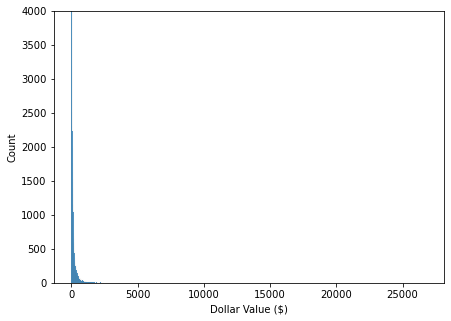

In [7]:
# Plot a sample of transaction dollar value distribution
sample = transaction.sample(0.0075).toPandas()
fig, ax = plt.subplots(1, figsize=(7, 5))
sns.histplot(sample['dollar_value'])
plt.ylim([0,4000])
plt.xlabel('Dollar Value ($)')

Transaction value per order is not capped with value as low as \\$0 and high as \$105193.9 in a single order. These transactions are clearly not reflective of our future transactions (BNPL firm typically set lower transactions value to avoid overly high value risky transaction) so we will remove these.

**Solution** - Outlier detection and removal. Using the generic outlier filtering method (filtering out `dollar_value` that lies outside the range of ($1.5-IQR, 1.5+IQR$) on the log-transformed `dollar_value` (log-transform to make the distribution more symmetric before applying the IQR filtering method) followed by reverting the transformation to obtain the lower and upper bound of transaction.

Text(0.5, 0, 'log(Dollar Value)')

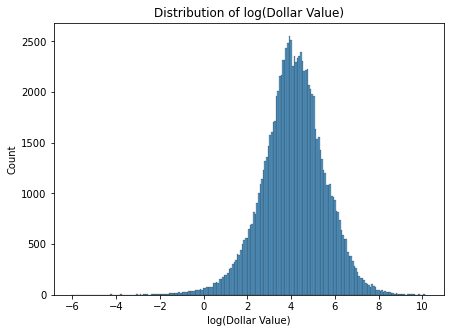

In [8]:
fig, ax = plt.subplots(1, figsize=(7, 5))
sns.histplot(np.log(sample['dollar_value']))
plt.title('Distribution of log(Dollar Value)')
plt.xlabel('log(Dollar Value)')

In [9]:
# Find new lower and upper bound for transactions
transaction1 = (transaction.select('dollar_value')
                           .withColumn('log_dollar_value', F.log(F.col('dollar_value'))))

# Find the lower and upper bound from the log-transformed dollar value
lwr, upr = transaction1.approxQuantile('log_dollar_value', [0.25, 0.75], 0.01)
iqr = upr - lwr
lwr_bound = lwr - 1.5 * iqr
upr_bound = upr + 1.5 * iqr

# Revert the log-transformation to get the actual value of the bounds
lwr_bound, upr_bound = np.exp(lwr_bound), np.exp(upr_bound)
print(f"Range of Accepted Transaction Value per order: ${lwr_bound} - ${upr_bound}")


Range of Accepted Transaction Value per order: $1.7960279869146518 - $2107.641586422376


The `dollar_value` range per transaction is now much smaller and we found that it is comparable to the upper bound with the **industry leading competitor (Afterpay)** which has a **maximum limit per transaction of $1500**.
<br>
<br>

### Issue 4: Missing information on weekly income when joining the consumers' SA2 region codes to the respective median weekly personal income in the region

In [10]:
# Read the consumer joined sa2 and abs census joined sa2 datasets
consumer_region_sa2 = (spark.read
                            .parquet("curated/consumer_regions"))

census_with_sa2 = (spark.read
                        .parquet("curated/census")
                        .select(['sa2_code','median_tot_prsnl_inc_weekly']))

# Find percentage of consumer without weekly income information
consumer_join_census = consumer_region_sa2.join(census_with_sa2, 'sa2_code', how='left')

# 1 consumer's postcode might belong to up to 3 different SA2 codes, so we take
# the average of these 3 regions' income
consumer_join_census = (consumer_join_census.groupby('consumer_id')
                                            .agg(F.mean('median_tot_prsnl_inc_weekly')
                                                  .alias('weekly_income')))

missing_income_info = consumer_join_census.select(
            F.count(
                F.when(
                    F.isnull('weekly_income'), 1
                )
            )
        ).collect()[0][0]

print(f"Number of Customer with Missing Income Info: {missing_income_info} \
        ({(missing_income_info/consumer.count())*100:.2f}%)")


Number of Customer with Missing Income Info: 58314         (11.66%)


**Solution** - Since there are only about 11.7\% missing weekly income in consumer data, we decided to **impute** the missing values based on the **median weekly income of all consumers**.


In [11]:
print(f"Median Consumer Income for Imputation: ${consumer_join_census.approxQuantile('weekly_income', [0.5], 0.001)[0]}")

Median Consumer Income for Imputation: $752.0


<br>
<br>

### <a name="findings"></a>Other Findings: 
### 1. Some merchants have high but inconsistent monthly revenue

In [12]:
# Show the two merchants who have similar magnitude of sales but widely different
# monthly sales deviation
merchant_sales = spark.read.parquet("curated/merchant_sales")

merchant_1 = (merchant_sales.where(F.col('merchant_abn')==36758807067)
                            .groupby(F.date_trunc("month",
                                                  F.col('order_datetime')))
                            .agg(F.sum("sales_revenue"))
                            .toPandas())

merchant_2 = (merchant_sales.where(F.col('merchant_abn')==78916025936)
                            .groupby(F.date_trunc("month",
                                                  F.col('order_datetime')))
                            .agg(F.sum("sales_revenue"))
                            .toPandas())

merchant_1['month_year'] = merchant_1['date_trunc(month, order_datetime)'].dt.strftime('%Y-%m')
merchant_1 = merchant_1.sort_values('month_year')
merchant_2['month_year'] = merchant_2['date_trunc(month, order_datetime)'].dt.strftime('%Y-%m')
merchant_2 = merchant_2.sort_values('month_year')


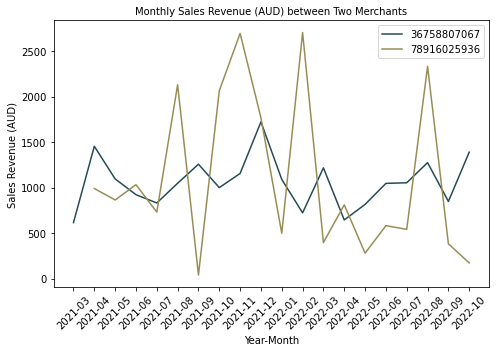

In [13]:
# Plot two merchants with different deviation in monthly sales revenue
fig, ax = plt.subplots(1, figsize=(7, 5))
ax = sns.lineplot(merchant_1['month_year'],merchant_1['sum(sales_revenue)'], color='#234a55', sort=True)
ax = sns.lineplot(merchant_2['month_year'],merchant_2['sum(sales_revenue)'], color='#988c55', sort=True)
fig = ax.figure

ax.xaxis.set_tick_params(labelsize=10)
ax.yaxis.set_tick_params(labelsize=10)
ax.set_ylabel('Sales Revenue (AUD)', fontsize=10)
ax.set_xlabel('Year-Month', fontsize=10)

plt.xticks(rotation=45)
plt.legend(['36758807067','78916025936'], fontsize=10)
plt.title("Monthly Sales Revenue (AUD) between Two Merchants", fontsize=10)

fig.tight_layout()
fig.savefig('../plots/stable_merchant.png', dpi=300)


Merchant with abn 78916025936 has **high variations in their earnings** on average (**unstable sales performance**) to the point where they had close to 0 sales revenue on 2021-09. Merchant with abn 36758807067 has a more stable monthly revenue in comparison, which means that we can expect to receive consistent monthly commission from them. As a newly established firm, we would want to **avoid merchants** with inconsistent monthly revenue.
<br>
<br>

### 2. Some merchants have high average customer spending but low customer base median weekly income

In [14]:
# Find merchants with large difference in average customer spending and median customer weekly income
merchant_df = pd.read_parquet("curated/final_merchant_statistics")
income = merchant_df.sort_values('median_customer_income', ascending=True)[:3][['merchant_abn','median_customer_income','mean_spending']]
income

,merchant_abn,median_customer_income,mean_spending
494,53877856360,435.500000,2045.324480
811,83199298021,499.666667,1971.663730
958,97590358496,561.000000,1129.362111


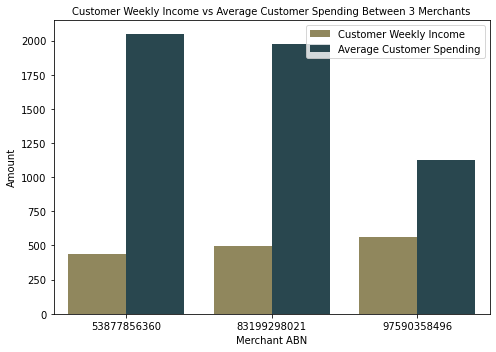

In [15]:
# Plot the difference in average customer spending and income
data = {'Merchant ABN':[53877856360,83199298021,97590358496,53877856360,83199298021,97590358496],
        'variables':['Customer Weekly Income','Customer Weekly Income','Customer Weekly Income', \
               'Average Customer Spending','Average Customer Spending','Average Customer Spending'],
        'Amount':[435.5,499.67,561,2045.32, 1971.66,1129.36]}

data = pd.DataFrame(data)

fig, ax = plt.subplots(1, figsize=(7, 5))
sns.barplot(x='Merchant ABN',y='Amount', hue='variables', data=data, palette=['#988c55','#234a55'])

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[:], labels=labels[:], fontsize=10)
ax.xaxis.set_tick_params(labelsize=10)
ax.yaxis.set_tick_params(labelsize=10)
ax.set_ylabel('Amount', fontsize=10)
ax.set_xlabel('Merchant ABN', fontsize=10)
plt.title('Customer Weekly Income vs Average Customer Spending Between 3 Merchants', fontsize=10)

fig.tight_layout()
fig.savefig('../plots/income_spending.png', dpi=300)

The first two merchants have high average customer spending (about \\$2000, split into 5 installments = \$400/week) but their median customer income is only about \\$400+/week. Taking Australian's living costs into account, they **might not be able to afford their weekly installments**. Thus, we want to avoid merchants who tend to attract customers with high credit-risk.
<br>
<br>

### 3. Some merchants have high number of orders but low average value per order and vice versa

This result shows that when considering merchants, we need to consider their average transaction value per order and number of orders. A **high number of orders** would **increase our firm's exposure** and a **high average transaction value per order** means that we could **earn more commission per order**.

### 4. Some merchants have high number of returning customers

We believe this is an important metric to consider as we could potentially **increase our exposure and customer conversion rate** (customers convert from using competitors platform to using our firm's BNPL platform) by onboarding merchants with high returning customers.

### <a name="fraud-finding"></a>5. Consumers' fraud rate directly correlates to their total spendings on the day 

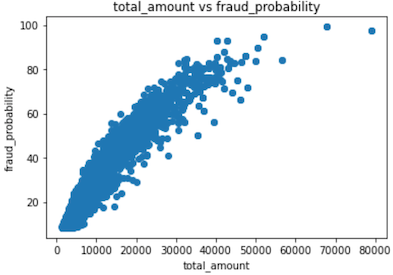

Based on the plots above, we clearly see a **strong linear relationship** between **consumers' daily fraud rate** and their **total spendings on the day** (with $R^2$-value as high as **0.82**) from the given customer fraud data, which only covers a small subsample from the transaction dataset. 

### 6. No major patterns or relationships found using the merchant fraud dataset

Using the merchant fraud dataset, we **plotted various metrics** such as sales revenue, number of orders, average value of each order on the day **against the daily merchants fraud rate** and turned out there were **no patterns and correlations**. Besides, there were only 61 unique `merchants_abn` out of 4026 valid merchants (**1.5\% of the overall merchants**) fraud data available. As such, we decided to discard the merchant fraud data from our final analysis to avoid adding unnecessary noise to the data.
<br>
<br>
<br>
<br>


# <a name="preprocessing"></a>Preprocessing and Feature Engineering

This section details the **extract, transform and load (ETL) processes** done in the final product.

### <a name="fraud"></a>Modelling Consumers Daily Fraud Rate

Based on the findings ([5.](#fraud-finding)), we trained a **Linear Regression model** on the given consumer fraud dataset and the unfiltered transaction datasets. We then use this model to **predict the remaining consumers' daily fraud rate in the transaction datasets** that were not in the consumer fraud dataset.

Assuming that if it turns out that the consumer committed fraud on the day, we/merchant **lose the full amount** equals to the **total dollar value** the customer spent on the merchant on the day.

$$\begin{align}
&\text{Earning from Customer } x \text{ on Day }y \\
&=\left\{
\begin{array}{ll}
\text{Total Customer }x\text{ spending on the merchant on day }y & \text{with probability } 1-P(\text{customer }x\text{ fraud rate on day }y) \\
-\text{ Total Customer }x\text{ spending on the merchant on day }y & \text{with probability } P(\text{fraud rate on day }y) 
\end{array}
\right.
\end{align}$$

We then create a risk-adjusted revenue metric to encode the fraud information of each merchants' consumer base.

$$\text{Risk-adjusted Earning from Customer }x\text{ on Day }y = \mathbb{E}\left(\text{Earning from Customer } x \text{ on Day }y\right)$$

$$\text{Risk-adjusted Revenue of Merchant} = \sum_{y=1}^l\sum_{x=1}^{n}\mathbb{E}\left(\text{Earning from Customer } x \text{ on Day }y\right)$$
where $l$ denotes the last day of sales in the transaction data, $n$ denotes the number of customer on day $y$

The intuition behind this metric is that if **most customers from merchant $z$ has high fraud rate** (eg. 80\%), then

$$\begin{align}
&\mathbb{E}\left(\text{Earning from Customer } x \text{ on Day }y\right) < 0\\
&\implies\text{Risk-adjusted Earning from Customer }x\text{ on Day }y < 0\\
&\implies\text{Risk-adjusted Revenue of Merchant} < 0
\end{align}$$

essentially resulting in **more losses than gain** in onboarding such merchants.

In [16]:
# pd.read_csv("/Users/oliver/Documents/GitHub/generic-buy-now-pay-later-project-group-19/notebooks/example_discounted_revenue.csv", index_col=0)

<br>

### <a name="outliers"></a>Removing outliers in transaction dataset

Based on the previous findings, we settled on the range of `dollar_value` and we **removed any transactions that do not lie in this range**. Removing these transactions gives us a **clear view of possible transactions values once we onboarded the merchants**. Limiting transactions to within this range also help to greatly reduce the risk that our firm has to bear.

In total, x records were discarded in the transaction datasets.
<br>
<br>

### <a name="Extract"></a>Extract and clean merchants' information from the merchant dataset

In [17]:
merchant.limit(1).toPandas()

,name,tags,merchant_abn
0,Felis Limited,"((furniture, home furnishings and equipment sh...",10023283211


The tag column includes information such as the `take_rate`, `revenue_level` and `tags`. Hence, we need to split this information into their respective columns. 

The tags are also generally noisy and uncleaned (eg. spelling errors, unnecessary punctuations, etc). Hence, we cleaned tags following the process below:

$$\text{Tokenisation}\implies\text{Case Standardisation}\implies\text{Punctuations/Number Removal}\implies\text{Spelling Autocorrection}\implies\text{Tokens Lemmatisation}$$

### Categorizing merchants' based on tags

After cleaning the tags, we merged the tags for each merchants using `,` as delimiter. Then we used `CountVectorizer` to one-hot-encode the tags for each merchants. An example of the cleaned merchant's table is as follow

In [18]:
merchant_with_tags = spark.read.parquet("/Users/oliver/Downloads/merchants_with_tags")
merchant_with_tags

name,merchant_abn,revenue_level,take_rate,antique_shop_sale,appliance_rent_leasing,art_dealer_gallery,artist_supply_craft_shop,bicycle_shop_sale_service,book,cable,card,clock,computer,computer_peripheral_equipment,computer_programming,data_processing,digital_good_book,equipment,except_appliance,eyeglass,flower,forest_supply,furniture,gift,health_beauty_spa,hobby,home_furnishing_equipment_shop,including_nursery,integrated_system_design_service,jewelry,jewelry_repair_shop,lawn_garden_supply_outlet,manufacturer,motor_vehicle_supply_new_part,movie,music,music_shop_musical_instrument,newspaper,novelty,nursery_stock,office_supply_printing_writing_paper,optical_good,optician,pay_television_radio_service,periodical,piano,repair,restoration_service,satellite,sheet_music,shoe_shop,silverware_shop,software,souvenir_shop,stationery,telecom,tent_owning_shop,tool,toy_game_shop,watch
Odio Tristique Ph...,93712553837,a,5.93,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
Donec Luctus Aliq...,93720983561,c,1.99,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
Quam Quis Diam Co...,93723130289,b,3.2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0
Justo Praesent Lu...,93726438981,a,5.91,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
Tellus Nunc Indus...,93732268717,d,1.04,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
Interdum Corporation,93740493847,b,3.19,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
Massa Suspendisse...,93741030320,a,6.72,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Aliquet Metus LLC,93765834526,a,6.7,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Arcu Eu Odio LLC,93880241546,b,4.81,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
At Velit Cras Ass...,93894215354,c,2.18,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [19]:
# Get the number of individual tags extracted from merchant data
merch_tag = spark.read.parquet("curated/merchants_with_tags")

# Exclude name, abn, revenue level and take rate
print(f"Number of individual tag: {len(merch_tag.columns[4:])}")

Number of individual tag: 57


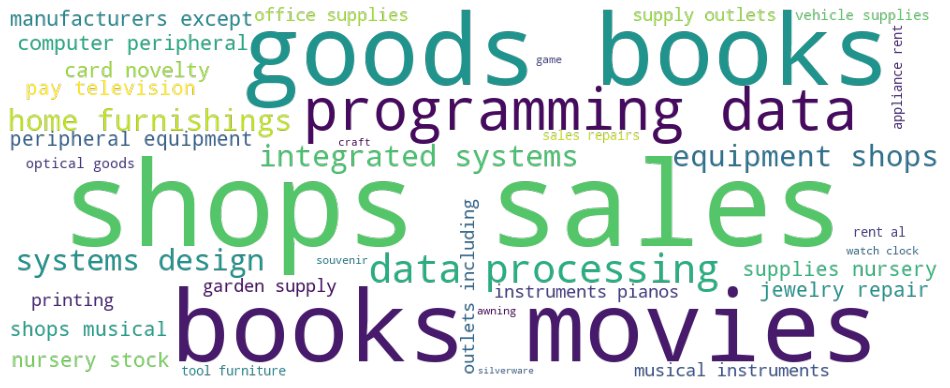

In [20]:
# Plot word cloud
comment_words = ''
 
# iterate through the csv file
for idx, row in merchant_df.iterrows():
     comment_words += row['tag']
        
from wordcloud import WordCloud, STOPWORDS

# Plot the WordCloud image  
wordcloud = WordCloud(mode = "RGBA", width = 1000, height = 400,
                background_color =None,
                min_font_size = 10).generate(comment_words)
   
fig, ax = plt.subplots(1, figsize=(13, 9))
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
fig.savefig('../plots/tag_cloud.png', transparent=True, dpi=300) 
plt.show()


<br>
<br>

### <a name="compute-metrics"></a>Compute merchants' performance and customer base metrics

After cleaning the dataset, we **aggregated different datasets** to obtain the following metrics that **directly/indirectly reflect the merchants' sales performance** as well as their **customers' repayability/credit-reliability**.

### Merchants' Sales Performance
- **Tags**: Specifying the categories/industry of the merchants products (one-hot encoded) <br><br>

- **Average Daily Revenue**: Average earnings from merchant per day

$$\text{Average Daily Revenue}=\frac{\text{Total revenue}}{\text{Number of days in the transaction data}}$$
<br>
- **Average Daily Order Count**: Average number of orders per day

$$\text{Average Daily Order Count}=\frac{\text{Total number of order}}{\text{Number of days in the transaction data}}$$
<br>
- **Average Value per Order**: Average number of orders per day

$$\text{Average Value per Order}=\frac{\text{Total revenue}}{\text{Total number of orders}}$$
<br>
- **Revenue Level**: Alphabetical order representation of the level of revenue bands (from high to low revenue band)

$$\text{Revenue Level}\in\{a,b,c,d,e\}$$
<br>
- **Average Daily Commission**: Average daily commission that BNPL firm receives if 100\% of the merchants' transaction is paid through the BNPL's platform

$$\text{Average Daily Commission}=\text{Average Daily Revenue}\times\text{Take rate}$$


- **Average Commission per Order**: Average commission that BNPL firm receives per order from the merchant

$$\text{Average Commission per Order}=\text{Average Value per Order}\times\text{Take rate}$$



- **Number of Sales Region**: Number of SA2 region that the merchant sells to. This directly reflects the **geographical reach** of the merchant. Ideally, to increase our firm's exposure, we would want a merchant with high value in this metric.
<br>
<br>

### Consumer Base Repayability and Credit Risk

- **Average Weekly Income of Consumer Base**: Average weekly income of the consumer base for the merchant. This indirectly tells us the **repayability of the target consumers**. Ideally, the higher the value, the less risky it is for the target consumers to default payments.



- **Number of Returning Customers**: Refers to number of returning customer (has ordered more than 2 times) of the merchant. This metric indirectly reflects the **exposure that our firm gain when onboarding the merchant**. The higher the number of returning customers, the more they will see our brand in checkout, thus **increasing brand memorability** and **potentially increasing customers conversion rate**. 



- **Average Customer Spending**: Refers to the average total spending of each customer on the merchant.

$$\text{Average Customer Spending}=\frac{\text{Total Revenue}}{\text{Number of Customer}}$$



- **Standard Deviation of Customer Spending**: Refers to how much the total spending of each customer on the merchant deviates on average.


- **Fraud Rate**: Refer to the probability of fraudulent transactions of each merchant.


- **Number of VIP Customers**: Refers to the number of high value customer (VIP) of the merchant. This metric counts the number of customer who has **atleast** spent **\$100** dollars on the merchant **and** has spent a total amount with the merchant exceeding the threshold derived below.

$$\text{Threshold} = E\;[\text{Total Spending of Customer | Merchant}] + 2 \times SE\;[\text{Total Spending of Customer | Merchant}]$$

<br>
<br>

# <a name="etl"></a>ETL Pipeline
This section details the **ETL pipeline** in the final product.

### Preprocessing pipeline

$$\text{Load Datasets}\implies\text{Consumers Daily Fraud Rate Modelling}\cup \text{Transaction Outlier Removal}\cup\text{Merchants' Information Extraction and Wrangling}\implies\text{Various Data Joins and Aggregations}\implies\text{Consumers' Income Imputation}\\\implies\text{Performance Metrics Computation}\implies\text{Final Merchants Statistics}$$

The final merchants statistics table:

In [21]:
# Show first 5 merchants stats
final_merch_stat = spark.read.parquet("curated/final_merchant_statistics").toPandas().drop('tags', axis=1)
final_merch_stat.head()

,merchant_abn,name,tag,revenue_level,take_rate,sales_revenue,discounted_sales_revenue,num_orders,approximate_fraudulent_orders,avg_daily_rev,...,overall_commission,discounted_overall_commission,overall_fraud_rate,sa2_region_count,median_customer_income,returning_customers,unique_customers,mean_spending,std_spending,vip_customers
0,10187291046,Ultricies Dignissim Lacus Foundation,"watch, clock, and jewelry repair shops",b,3.29,39692.723318,37093.230207,335,21.473308,65.607807,...,1305.890597,1220.367274,0.064099,457.0,795.024675,0.0,334.0,118.840489,84.569845,13.0
1,10364012396,Rutrum Justo Ltd,"music shops - musical instruments, pianos, and...",b,3.63,15850.202687,14689.433332,39,2.713981,26.198682,...,575.362358,533.226430,0.069589,73.0,815.747395,0.0,39.0,406.415454,269.743119,3.0
2,10385250025,Id Ltd,"computers, computer peripheral equipment, and...",a,5.54,332780.592272,307812.754995,666,47.490744,550.050566,...,18436.044812,17052.826627,0.071307,770.0,789.930632,0.0,660.0,504.213019,323.155406,33.0
3,10404542215,Consequat Foundation,"antique shops - sales, repairs, and restoratio...",a,6.93,0.000000,0.000000,0,0.000000,0.000000,...,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,10530696903,Ut Semper Industries,"books, periodicals, and newspapers",a,6.46,285399.463033,264347.137732,675,47.392892,471.734650,...,18436.805312,17076.825097,0.070212,744.0,797.279556,0.0,666.0,428.527722,289.309651,35.0


In [22]:
# Show first 5 merchants tags
merchants_with_tags = spark.read.parquet("curated/merchants_with_tags")
merchants_with_tags.limit(5)

name,merchant_abn,revenue_level,take_rate,antique_shop_sale,appliance_rent_leasing,art_dealer_gallery,artist_supply_craft_shop,bicycle_shop_sale_service,book,cable,card,clock,computer,computer_peripheral_equipment,computer_programming,data_processing,digital_good_book,equipment,except_appliance,eyeglass,flower,forest_supply,furniture,gift,health_beauty_spa,hobby,home_furnishing_equipment_shop,including_nursery,integrated_system_design_service,jewelry,jewelry_repair_shop,lawn_garden_supply_outlet,manufacturer,motor_vehicle_supply_new_part,movie,music,music_shop_musical_instrument,newspaper,novelty,nursery_stock,office_supply_printing_writing_paper,optical_good,optician,pay_television_radio_service,periodical,piano,repair,restoration_service,satellite,sheet_music,shoe_shop,silverware_shop,software,souvenir_shop,stationery,telecom,tent_owning_shop,tool,toy_game_shop,watch
Felis Limited,10023283211,e,0.18,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
Arcu Ac Orci Corp...,10142254217,b,4.22,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
Nunc Sed Company,10165489824,b,4.4,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
Ultricies Digniss...,10187291046,b,3.29,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
Enim Condimentum PC,10192359162,a,6.33,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0


In the final merchant stats table, there are merchants whose transactions are all **beyond our specified range** (\\$1.80 - \$2107.64) so they end up not having any transactions in the final merchant dataset, which explains the 0 revenue for certain merchants. These merchants will be handled differently in the ranking later.

<br>

# <a name="industry"></a>Merchant Segmentation

We have over **57 individual tags** from the merchants data which we will further segment them into different industries as follow.

### <a name="definitions"></a>Defining Segments

There are industries that experience **high growth during an economic boom** but **suffer tremendously during recession**. We call these **recession-vulnerable industries** and an example of this would be retail, hospitality and leisure industries. On the other hand, tech industry and repair industry are generally **recession-proof** as they have grown to be essentials in our daily life. As part of our diversification strategy, we aim to segment merchants into the following categories:

Credits: https://www.cnbc.com/2012/06/01/Industries-Hit-Hardest-by-the-Recession.html
<br>
<br>

- ### Recession-vulnerable industries:
    - **Luxury Goods** - High `avg_value_per_order` and non-service oriented industry such as jewelry and arts. This category should see low returning and vip customer rate as well as relatively high variance in customer spendings.
    - **Leisure Goods** - Hobbies, toys, books as well as outdoor activities essentials. Generally high variance in customer spendings.
    - **Home Furnishings** - Home furnishing industry. This industry should see high `avg_value_per_order` and `avg_daily_order`.
    - **Gifts & Souvenir** - Gifts, flowers, souvenir, etc industry. Generally low `avg_value_per_order` but high `avg_daily_order`.
    - **Clothing & Accessories** - Fashion and accessories industry.
    - **Office Equipments** - Office supplies, stationery etc.
<br>
<br>

- ### Recession-proof industries:
    - **Repair Services** - General repair services industry. This industry should see high `avg_value_per_order` and generally high number of order as well.
    - **Technology & Telecommunication** - electronic devices, telecommunication, systems and software-related industry. Generally high `total_avg_daily_rev` and high `avg_daily_order` due to how big the market is.
    - **Motor & Bicycles** - Motor, bicycle supplies and parts. 
    - **Health & Wellness** - Health related services.
   
<br>

In [23]:
# Example of how merchants are segmented 
import os
os.chdir("/Users/oliver/Documents/GitHub/generic-buy-now-pay-later-project-group-19")
import scripts.utilities.segment_utilities as SEGMENT
merchants_with_segments = SEGMENT.transform_segment(merchants_with_tags)
merchants_with_segments.head()

,merchant_abn,clothing and accessories,gifts souvenirs,health and wellness,home furnishings,leisure goods and services,luxury goods,miscellaneous,motor and bicycles,office equipments,repair services,tech and telecom
0,10023283211,0,0,0,1,0,0,1,0,0,0,0
1,10142254217,0,0,0,0,0,0,0,0,0,0,1
2,10165489824,1,0,0,0,0,1,1,0,0,0,0
3,10187291046,1,0,0,0,0,0,1,0,0,1,0
4,10192359162,0,0,0,0,1,0,0,0,0,0,0


Due to the nature of certain businesses, some merchants may belong to more than one segment. For instance, a merchant which sells jewelry and offer repair services will belong to both the `luxury goods` and `repair services` industry.
<br>
<br>

### <a name="segmentanalysis"></a>Segment Analysis

We analysed the **number of merchants**, **average performance of each merchant** as well as the **collective performance of merchants** under each segments.



In [24]:
# Get the high level summary of each segment
abn_by_segment = SEGMENT.get_segments_abn(merchants_with_segments)

segment_summary = {'segment':[],
                   'no_merchants':[],
                   'total_sales_revenue':[],
                   'total_no_order':[],
                   'total_avg_daily_order':[],
                   'total_avg_daily_commission':[],
                   'avg_no_sales_region':[]}

for segment in abn_by_segment.keys():
    if segment != 'miscellaneous':
        filtered_abn = merchant_df[merchant_df['merchant_abn'].isin(abn_by_segment[segment])]
        segment_summary['segment'].append(segment)
        segment_summary['total_sales_revenue'].append(filtered_abn['sales_revenue'].sum())
        segment_summary['no_merchants'].append(len(abn_by_segment[segment]))
        segment_summary['total_no_order'].append(filtered_abn['num_orders'].sum())
        segment_summary['total_avg_daily_order'].append(filtered_abn['avg_daily_orders'].sum())
        segment_summary['total_avg_daily_commission'].append(filtered_abn['avg_daily_commission'].sum())
        segment_summary['avg_no_sales_region'].append(filtered_abn['sa2_region_count'].mean())


palette = {'leisure goods and services':'#173038',
           'gifts souvenirs':'#a4c1c8',
           'home furnishings':'#234a55',
           'tech and telecom':'#66aac1',
           'clothing and accessories':'#988c55',
           'health and wellness':'#CFCAB4',
           'repair services':'#4c462a',
           'motor and bicycles':'#86b093'}

segment_summary = pd.DataFrame(segment_summary)
segment_summary

,segment,no_merchants,total_sales_revenue,total_no_order,total_avg_daily_order,total_avg_daily_commission,avg_no_sales_region
0,clothing and accessories,446,1.624712e+08,1448215,2393.743802,12587.592449,852.802410
1,gifts souvenirs,362,2.137027e+08,2483100,4104.297521,16321.649672,1086.964088
2,health and wellness,315,1.473851e+08,1059263,1750.847934,10503.469120,912.574603
3,home furnishings,649,2.965801e+08,1730489,2860.312397,20558.379195,678.674383
4,leisure goods and services,1221,6.658093e+08,6012307,9937.697521,51108.812734,915.496314
5,luxury goods,332,3.928223e+07,188304,311.246281,2539.864715,256.731707
6,motor and bicycles,321,1.428862e+08,518703,857.360331,11065.364704,702.044164
7,office equipments,161,7.758205e+07,170646,282.059504,5294.976342,603.149068
8,repair services,299,1.019010e+08,1192715,1971.429752,7818.100598,926.028112
9,tech and telecom,672,3.095223e+08,2194160,3626.710744,23160.259200,872.262763


### Top 5 segments by total sales revenue

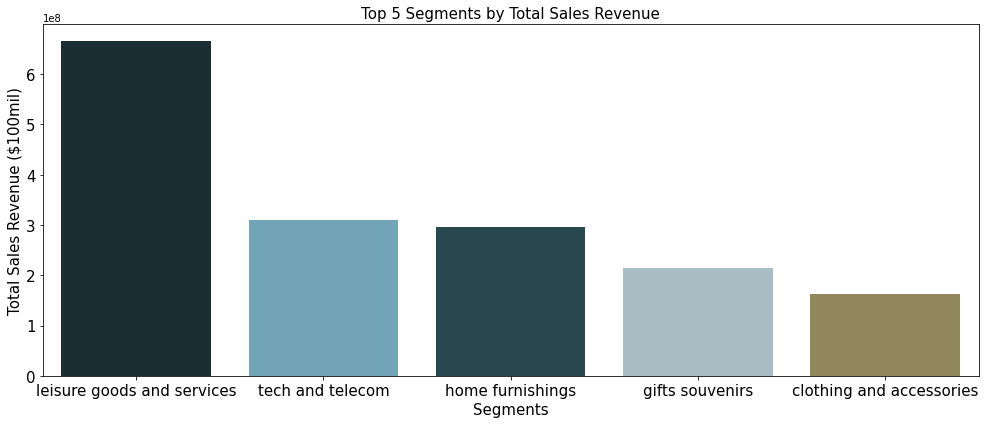

In [25]:
# Plot top 5 segments based on total sales revenue
plt.figure(figsize=(14,6))
order = segment_summary.groupby('segment').mean().sort_values('total_sales_revenue', ascending=False).index[:5]
sns.barplot(x='segment', y='total_sales_revenue', data=segment_summary, order=order, ci=False, palette=palette)
plt.xticks(fontsize=15)
plt.xlabel('Segments', fontsize=15)
plt.ylabel('Total Sales Revenue ($100mil)', fontsize=15)
plt.yticks(fontsize=15)
plt.title("Top 5 Segments by Total Sales Revenue", fontsize=15)
plt.tight_layout()
plt.savefig("plots/top_5_tot_sales_rev.png",dpi=300)

### Top 5 segments by total average daily number of orders


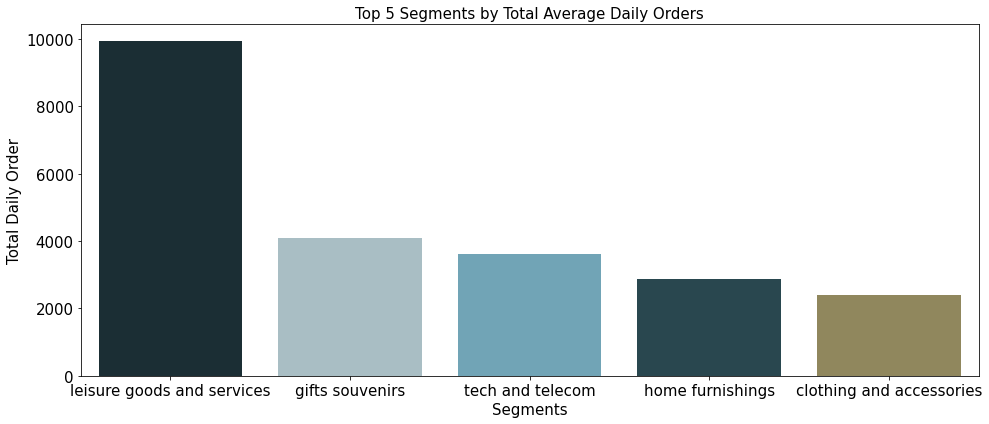

In [26]:
# Plot top 5 segments based on total average daily number of order
plt.figure(figsize=(14,6))
order = segment_summary.groupby('segment').mean().sort_values('total_avg_daily_order', ascending=False).index[:5]
sns.barplot(x='segment', y='total_avg_daily_order', data=segment_summary, order=order, ci=False, palette=palette)
plt.xticks(fontsize=15)
plt.xlabel('Segments', fontsize=15)
plt.ylabel('Total Daily Order', fontsize=15)
plt.yticks(fontsize=15)
plt.title("Top 5 Segments by Total Average Daily Orders", fontsize=15)
plt.tight_layout()
plt.savefig("plots/top_5_tot_daily_order.png",dpi=300)

### Top 5 segments by total number of orders

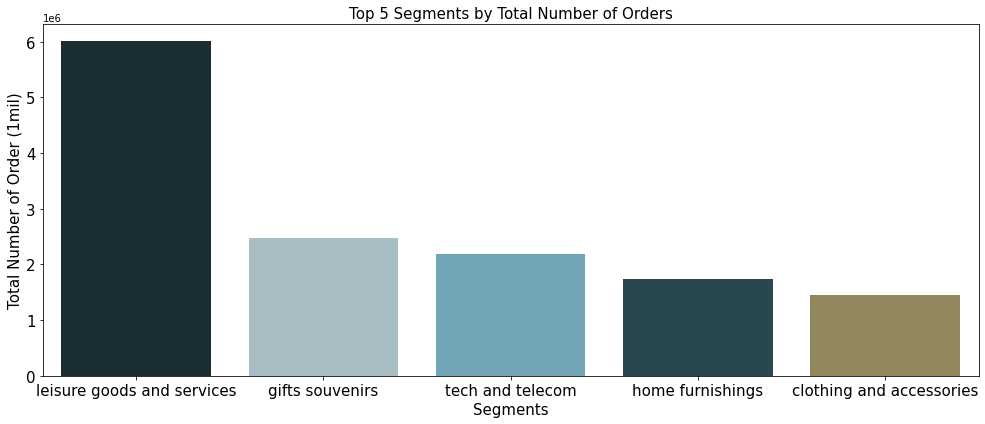

In [27]:
# Plot top 5 segments based on total number of order
plt.figure(figsize=(14,6))
order = segment_summary.groupby('segment').mean().sort_values('total_no_order', ascending=False).index[:5]
sns.barplot(x='segment', y='total_no_order', data=segment_summary, order=order, ci=False, palette=palette)
plt.xticks(fontsize=15)
plt.xlabel('Segments', fontsize=15)
plt.ylabel('Total Number of Order (1mil)', fontsize=15)
plt.yticks(fontsize=15)
plt.title("Top 5 Segments by Total Number of Orders", fontsize=15)
plt.tight_layout()
plt.savefig("plots/top_5_tot_no_order.png",dpi=300)

### Top 5 segments by total average daily commission

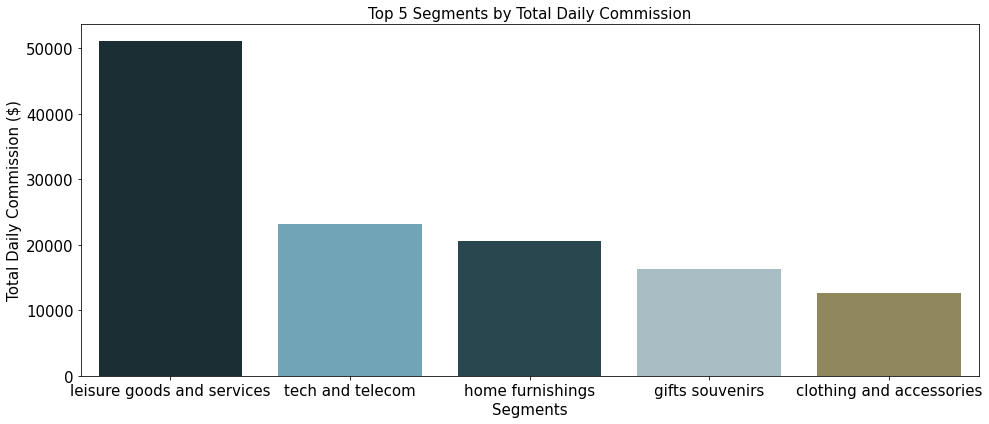

In [28]:
# Plot top 5 segments based on total daily commission
plt.figure(figsize=(14,6))
order = segment_summary.groupby('segment').mean().sort_values('total_avg_daily_commission', ascending=False).index[:5]
sns.barplot(x='segment', y='total_avg_daily_commission', data=segment_summary, order=order, ci=False, palette=palette)
plt.xticks(fontsize=15)
plt.xlabel('Segments', fontsize=15)
plt.ylabel('Total Daily Commission ($)', fontsize=15)
plt.yticks(fontsize=15)
plt.title("Top 5 Segments by Total Daily Commission", fontsize=15)
plt.tight_layout()
plt.savefig("plots/top_5_tot_daily_commission.png",dpi=300)

### Top 5 segments by average number of sales region

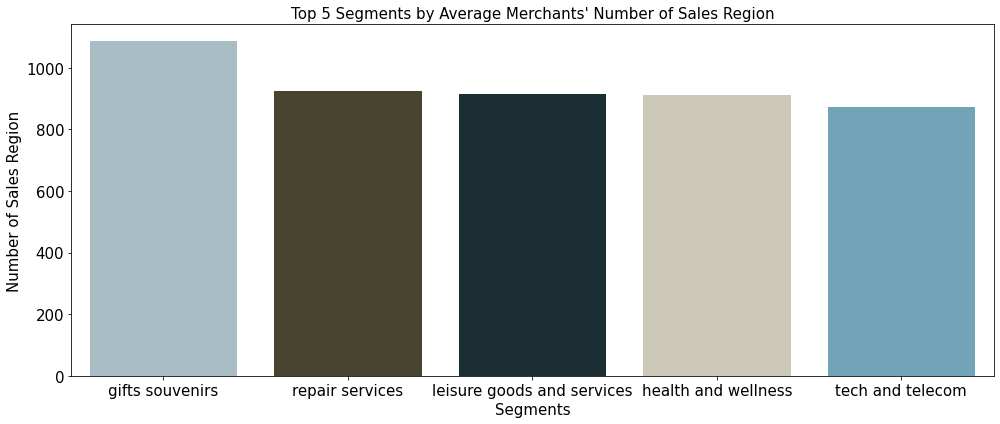

In [29]:
# Plot top 5 segments based on average merchants' number of sales region
plt.figure(figsize=(14,6))
order = segment_summary.groupby('segment').mean().sort_values('avg_no_sales_region', ascending=False).index[:5]
sns.barplot(x='segment', y='avg_no_sales_region', data=segment_summary, order=order, ci=False, palette=palette)
plt.xticks(fontsize=15)
plt.xlabel('Segments', fontsize=15)
plt.ylabel('Number of Sales Region', fontsize=15)
plt.yticks(fontsize=15)
plt.title("Top 5 Segments by Average Merchants' Number of Sales Region", fontsize=15)
plt.tight_layout()
plt.savefig("plots/top_5_avg_no_sales_region.png",dpi=300)

Based on the various segments metrics comparison plots above, we can see that `leisure goods and services`, `tech and telecom`, `home furnishings` and `gifts souvenirs` **consistently** appear as top 4 contenders.
<br>
<br>
<br>


### <a name="selections"></a>Final Selections

Based on the analysis above, coupled with forecasted growth rate in next 5 years of the segment. We arrived at the following selections.

### Recession-vulnerable 
- ### Gift & Souvenirs
    - Post-pandemic projected annual growth rate of **6.7%** ([link](https://www.marketwatch.com/press-release/personalized-gifts-market-is-estimated-to-accelerate-industry-growth-in-consumer-goods-sector-with-top-key-players-till-2028-no-of-pages-107-2022-09-28))
    - High average daily number of orders (greater exposure for the firm's growth)
    - High average daily commission
    - High number of returning customer (greater customer conversion rate)
    
- ### Leisure Goods & Services
    - Post-pandemic projected annual growth rate of **16%** ([link](https://simplywall.st/markets/us/consumer-discretionary/leisure))
    - Highest number of merchants
    - High average daily number of orders (greater exposure for the firm's growth)
    - High average daily commission
    - High number of returning customer (greater customer conversion rate)
    
- ### Home Furnishings
    - Post-pandemic projected annual growth rate of **22.52%** ([link](https://www.statista.com/outlook/dmo/ecommerce/furniture/australia))
    - High number of merchants
    - High total daily order from the segment
    - High total daily revenue from the segment
    
### Recession-proof
- ### Technology & Telecommunication
    - High post-pandemic projected annual growth rate of **27%** for IT industry overall and **11%** for telecommunication industry. ([link](https://simplywall.st/markets/au/tech))
    - High number of merchants
    - High total number of orders
    - High average daily revenue
    
<br>

# <a name="ensemble-ranking"></a>Ensemble-Averaging Ranking Model

Our model follows a **ranking by committee model** where we apply simple min-max scaling to scale records under each metric column and output the merchants' metric value into the range of 0 to 1. Then, using an **ensemble averaging** technique, for each merchant, we find the **unweighted sum of all their metrics values** as their **final output**. Finally, we rank the merchants based on their final value under this model.

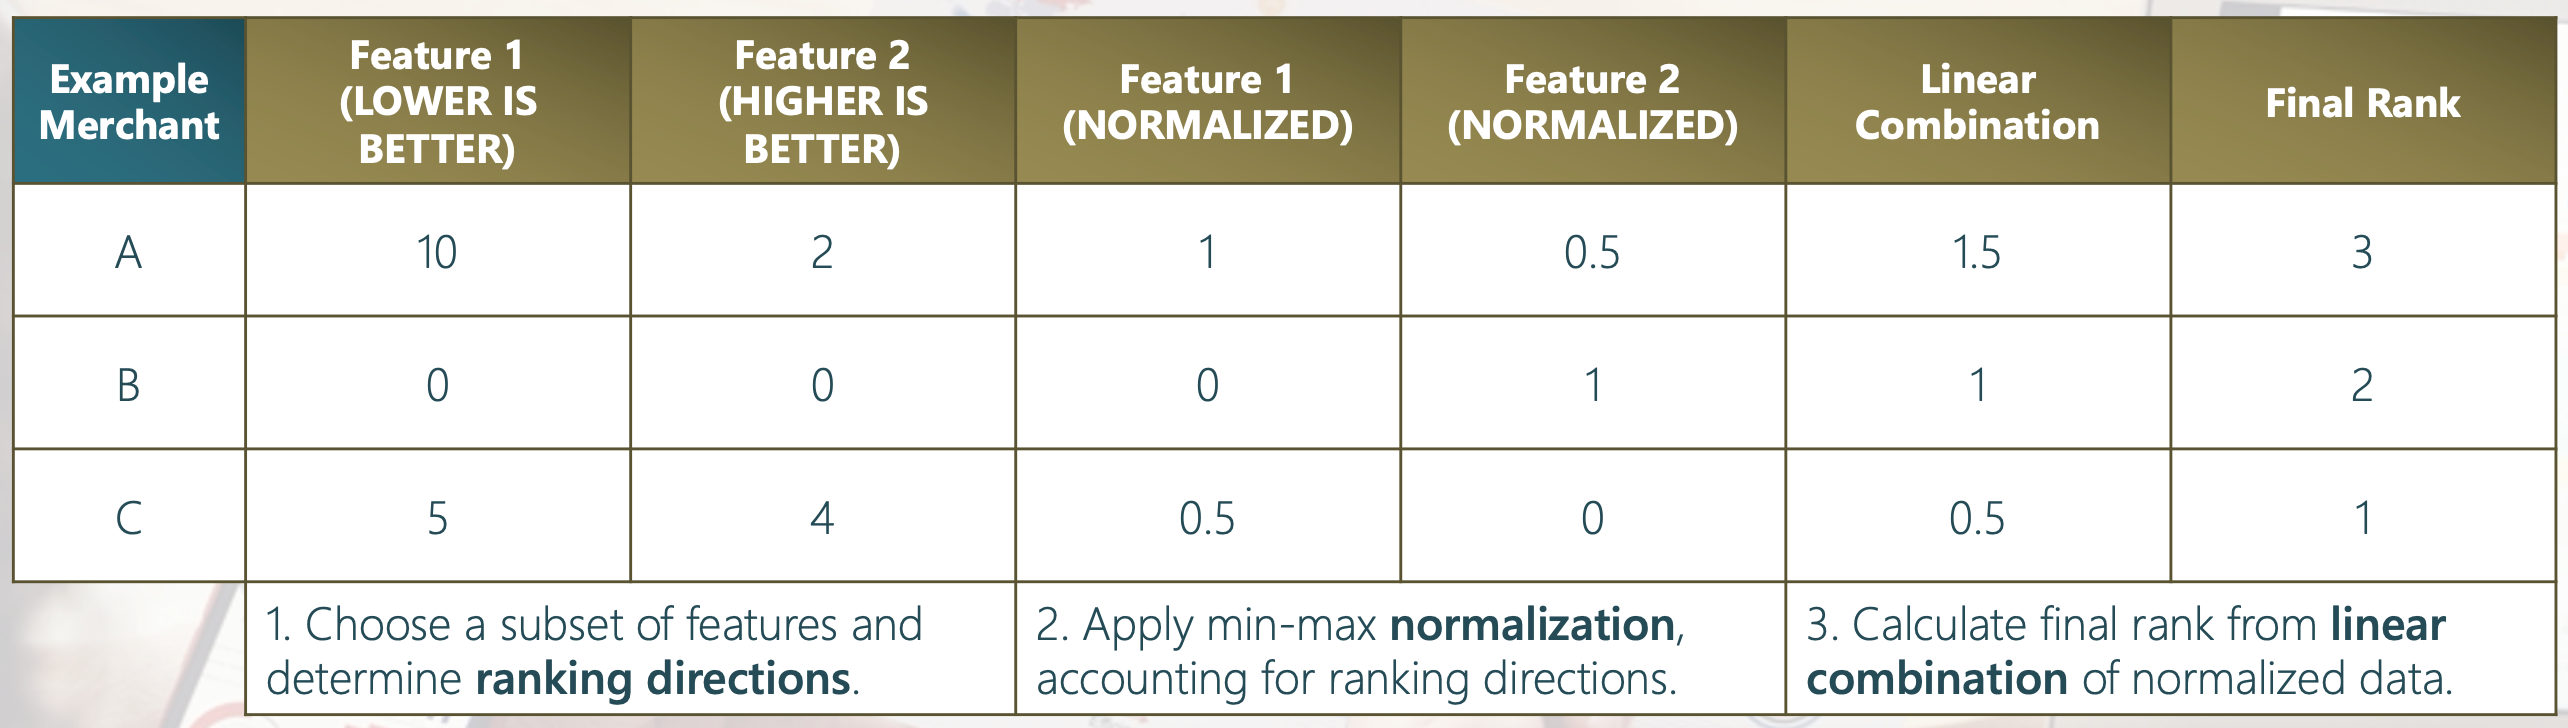

### Simple intuitions

The model essentially takes into account the **opinion of several experts** rather than relying only on one.

### Advantages
- Results are highly interpretable.
- Bias of each metrics is greatly reduced.
- Computationally cheap based on the size of the merchants dataset.
- Weights of each metrics can be tailored based on domain knowledge.

<br>
<br>

# <a name="result"></a>Top Merchants

Using the ranking model, the top 100 merchants overall as well as top 10 merchants under each segments are specified as follow

### Top 100 merchants overall

In [30]:
top_100 = pd.read_csv("models/top-100-merchants.csv")
top_100

,rank,merchant_abn,name,tags,tag,numd_sa2_code,returning_customers,unique_customers,median_weekly_income,commission_avg_tot_dollar_value_monthly,...,minmax_returning_customers,minmax_unique_customers,minmax_median_weekly_income,minmax_commission_avg_tot_dollar_value_monthly,minmax_avg_num_order_id_monthly,minmax_avg_discounted_value,minmax_stddev_tot_dollar_value_monthly,minmax_rate_fraud_order,minmax_stddev_tot_discounted_value_daily,average_rank
0,1,49891706470,Non Vestibulum Industries,"((teNt and awning shops), (a), (take rate: 5.80))",tent and awning shops,2222.0,24037.0,24078.0,815.703894,19807.260486,...,0.001288,0.000125,0.949333,0.333000,0.139010,0.989872,0.736454,0.012217,0.531271,0.369257
1,2,63290521567,Vehicula Pellentesque Corporation,"((artist supply and craft shops), (a), (take r...",artist supply and craft shops,2222.0,23346.0,24058.0,815.663697,13544.646461,...,0.029998,0.000955,0.949344,0.543891,0.414487,0.991384,0.454313,0.011242,0.341656,0.373727
2,3,45629217853,Lacus Consulting,"[[gift, Card, novelty, and souvenir shops], [a...","gift, card, novelty, and souvenir shops",2222.0,23944.0,24080.0,815.679442,27867.742923,...,0.005152,0.000042,0.949340,0.061567,0.246329,0.984823,0.878715,0.016873,0.655372,0.379821
3,4,89726005175,Est Nunc Consulting,"((tent and awning shops), (a), (take rate: 6.01))",tent and awning shops,2222.0,23930.0,24079.0,815.688162,25495.901715,...,0.005734,0.000083,0.949338,0.141438,0.249056,0.983478,0.917480,0.018450,0.666423,0.393148
4,5,64203420245,Pede Nonummy Corp.,"((tent and awning shops), (c), (take rate: 2.86))",tent and awning shops,2222.0,24055.0,24081.0,815.686432,10281.625409,...,0.000540,0.000000,0.949338,0.653771,0.092908,0.989884,0.776352,0.012593,0.556897,0.403228
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,96,87639550697,Mauris Consulting,"[[digital gooDs: books, movies, music], [b], [...","digital goods: books, movies, music",2195.0,729.0,12062.0,807.286055,1365.756752,...,0.969711,0.499128,0.951584,0.954009,0.942374,0.977419,0.093122,0.025130,0.098514,0.552315
96,97,13839274306,Sit Amet Consectetuer PC,"([computErs, computer peripheral equipment, an...","computers, computer peripheral equipment, and ...",2187.0,674.0,11459.0,809.736056,2869.517884,...,0.971996,0.524169,0.950929,0.903370,0.945668,0.971514,0.106112,0.030185,0.108535,0.552824
97,98,54874856789,Euismod Urna Incorporated,"[[Hobby, toy and game shops], [a], [take rate:...","hobby, toy and game shops",2193.0,565.0,10806.0,827.607390,2705.696420,...,0.976525,0.551287,0.946151,0.908887,0.950165,0.972118,0.092340,0.028728,0.095913,0.553517
98,99,13565102775,Malesuada LLP,"[(gIft, card, novelty, and souvenir shops), (c...","gift, card, novelty, and souvenir shops",2193.0,816.0,11968.0,807.868265,1022.755545,...,0.966096,0.503032,0.951428,0.965559,0.942294,0.975805,0.097766,0.025535,0.097548,0.553812


### Top 10 gifts souvenirs merchants

In [31]:
top_segment = pd.read_csv("models/segmented_top_100.csv").drop(['tags','tag'], axis=1)
top_segment[top_segment['segment']=='gifts souvenirs'][:10]

,rank,merchant_abn,name,numd_sa2_code,returning_customers,unique_customers,median_weekly_income,commission_avg_tot_dollar_value_monthly,avg_num_order_id_monthly,avg_discounted_value,...,minmax_unique_customers,minmax_median_weekly_income,minmax_commission_avg_tot_dollar_value_monthly,minmax_avg_num_order_id_monthly,minmax_avg_discounted_value,minmax_stddev_tot_dollar_value_monthly,minmax_rate_fraud_order,minmax_stddev_tot_discounted_value_daily,average_rank,segment
3,3,45629217853,Lacus Consulting,2222.0,23944.0,24080.0,815.679442,27867.742923,10317.761905,36.241946,...,0.000042,0.949340,0.061567,0.246329,0.984823,0.878715,0.016873,0.655372,0.379821,gifts souvenirs
7,6,24852446429,Erat Vitae LLP,2222.0,24068.0,24080.0,815.688576,12174.764122,13690.000000,28.346671,...,0.000042,0.949338,0.590021,0.000000,0.989210,0.890410,0.013098,0.640080,0.407220,gifts souvenirs
9,7,43186523025,Lorem Ipsum Sodales Industries,2222.0,23814.0,24076.0,815.705212,19246.311511,9564.095238,42.176060,...,0.000208,0.949333,0.351890,0.301381,0.981526,0.935618,0.019871,0.690370,0.424075,gifts souvenirs
16,13,80324045558,Ipsum Dolor Sit Corporation,2222.0,23652.0,24070.0,815.721121,5047.475934,8899.666667,36.134051,...,0.000457,0.949329,0.830029,0.349915,0.984883,0.733576,0.017631,0.539640,0.442274,gifts souvenirs
25,21,94493496784,Dictum Phasellus In Institute,2222.0,18868.0,23660.0,816.382063,24525.357742,4722.142857,85.995808,...,0.017483,0.949152,0.174120,0.655066,0.957178,0.936444,0.043862,0.734101,0.468346,gifts souvenirs
27,22,32361057556,Orci In Consequat Corporation,2222.0,16653.0,23396.0,816.565756,29696.044047,4084.571429,102.863786,...,0.028447,0.949103,0.000000,0.701638,0.947806,0.966755,0.051628,0.733520,0.468698,gifts souvenirs
30,24,60956456424,Ultricies Dignissim LLP,2219.0,17480.0,23499.0,816.148547,17926.901282,4319.285714,82.838771,...,0.024169,0.949215,0.396320,0.684493,0.958933,0.830462,0.040670,0.620670,0.478001,gifts souvenirs
32,25,79417999332,Phasellus At Company,2222.0,18813.0,23731.0,816.193086,21512.201599,4724.523810,86.055398,...,0.014535,0.949203,0.275587,0.654892,0.957145,0.948570,0.043658,0.720937,0.478287,gifts souvenirs
35,27,81219314324,Faucibus Leo Ltd,2222.0,8382.0,21127.0,818.312766,13512.865834,2403.476190,82.876527,...,0.122674,0.948636,0.544961,0.824436,0.958912,0.464749,0.042006,0.368497,0.492661,gifts souvenirs
48,39,80682333501,Orci Corp.,2195.0,2048.0,15515.0,828.619855,973.054705,1176.190476,15.890770,...,0.355731,0.945880,0.967233,0.914084,0.996131,0.043232,0.007207,0.042002,0.519856,gifts souvenirs


### Top 10 leisure goods and services merchants

In [32]:
top_segment[top_segment['segment']=='leisure goods and services'][:10]

,rank,merchant_abn,name,numd_sa2_code,returning_customers,unique_customers,median_weekly_income,commission_avg_tot_dollar_value_monthly,avg_num_order_id_monthly,avg_discounted_value,...,minmax_unique_customers,minmax_median_weekly_income,minmax_commission_avg_tot_dollar_value_monthly,minmax_avg_num_order_id_monthly,minmax_avg_discounted_value,minmax_stddev_tot_dollar_value_monthly,minmax_rate_fraud_order,minmax_stddev_tot_discounted_value_daily,average_rank,segment
0,1,49891706470,Non Vestibulum Industries,2222.0,24037.0,24078.0,815.703894,19807.260486,11786.952381,27.155789,...,0.000125,0.949333,0.333000,0.139010,0.989872,0.736454,0.012217,0.531271,0.369257,leisure goods and services
1,2,63290521567,Vehicula Pellentesque Corporation,2222.0,23346.0,24058.0,815.663697,13544.646461,8015.666667,24.434463,...,0.000955,0.949344,0.543891,0.414487,0.991384,0.454313,0.011242,0.341656,0.373727,leisure goods and services
2,3,45629217853,Lacus Consulting,2222.0,23944.0,24080.0,815.679442,27867.742923,10317.761905,36.241946,...,0.000042,0.949340,0.061567,0.246329,0.984823,0.878715,0.016873,0.655372,0.379821,leisure goods and services
4,4,89726005175,Est Nunc Consulting,2222.0,23930.0,24079.0,815.688162,25495.901715,10280.428571,38.662410,...,0.000083,0.949338,0.141438,0.249056,0.983478,0.917480,0.018450,0.666423,0.393148,leisure goods and services
5,5,64203420245,Pede Nonummy Corp.,2222.0,24055.0,24081.0,815.686432,10281.625409,12418.095238,27.133349,...,0.000000,0.949338,0.653771,0.092908,0.989884,0.776352,0.012593,0.556897,0.403228,leisure goods and services
11,9,91923722701,Euismod Urna Institute,2222.0,12869.0,22730.0,813.406766,2583.071986,3253.809524,14.736841,...,0.056105,0.949948,0.913016,0.762322,0.996772,0.110954,0.005860,0.087777,0.434806,leisure goods and services
12,10,64403598239,Lobortis Ultrices Company,2222.0,20521.0,23875.0,815.891706,26662.557910,5406.714286,73.156849,...,0.008555,0.949283,0.102151,0.605061,0.964312,0.903191,0.036452,0.667103,0.438348,leisure goods and services
13,11,72472909171,Nullam Consulting,2222.0,19097.0,23744.0,815.543349,21518.717799,4840.190476,65.740526,...,0.013995,0.949376,0.275368,0.646443,0.968433,0.733291,0.031879,0.559248,0.438457,leisure goods and services
14,12,57900494384,Porttitor Tellus Corporation,2222.0,12132.0,22468.0,817.218662,4220.197439,3081.000000,20.092891,...,0.066985,0.948928,0.857887,0.774945,0.993796,0.140886,0.007855,0.109741,0.439695,leisure goods and services
15,13,80324045558,Ipsum Dolor Sit Corporation,2222.0,23652.0,24070.0,815.721121,5047.475934,8899.666667,36.134051,...,0.000457,0.949329,0.830029,0.349915,0.984883,0.733576,0.017631,0.539640,0.442274,leisure goods and services


### Top 10 home furnishings merchants

In [33]:
top_segment[top_segment['segment']=='home furnishings'][:10]

,rank,merchant_abn,name,numd_sa2_code,returning_customers,unique_customers,median_weekly_income,commission_avg_tot_dollar_value_monthly,avg_num_order_id_monthly,avg_discounted_value,...,minmax_unique_customers,minmax_median_weekly_income,minmax_commission_avg_tot_dollar_value_monthly,minmax_avg_num_order_id_monthly,minmax_avg_discounted_value,minmax_stddev_tot_dollar_value_monthly,minmax_rate_fraud_order,minmax_stddev_tot_discounted_value_daily,average_rank,segment
6,6,24852446429,Erat Vitae LLP,2222.0,24068.0,24080.0,815.688576,12174.764122,13690.000000,28.346671,...,0.000042,0.949338,0.590021,0.000000,0.989210,0.890410,0.013098,0.640080,0.407220,home furnishings
8,7,43186523025,Lorem Ipsum Sodales Industries,2222.0,23814.0,24076.0,815.705212,19246.311511,9564.095238,42.176060,...,0.000208,0.949333,0.351890,0.301381,0.981526,0.935618,0.019871,0.690370,0.424075,home furnishings
47,39,80682333501,Orci Corp.,2195.0,2048.0,15515.0,828.619855,973.054705,1176.190476,15.890770,...,0.355731,0.945880,0.967233,0.914084,0.996131,0.043232,0.007207,0.042002,0.519856,home furnishings
49,40,98269572896,Eget Laoreet Posuere PC,2221.0,6837.0,20327.0,815.123535,6719.697973,2127.857143,82.226618,...,0.155897,0.949489,0.773717,0.844569,0.959273,0.406477,0.041661,0.356714,0.520418,home furnishings
82,68,21772962346,Purus Gravida Sagittis Ltd,2216.0,3885.0,18183.0,813.534973,16282.647864,1597.095238,143.354864,...,0.244934,0.949913,0.451690,0.883339,0.925308,0.525093,0.073337,0.494268,0.538916,home furnishings
93,78,42355028515,Eu Inc.,2213.0,4294.0,18225.0,814.781475,15634.715584,1640.333333,148.946630,...,0.243189,0.949580,0.473508,0.880180,0.922201,0.566564,0.077257,0.506419,0.544454,home furnishings
99,83,76314317957,Semper Corp.,2210.0,3853.0,17971.0,811.431862,14073.673302,1568.761905,141.041940,...,0.253738,0.950476,0.526076,0.885408,0.926593,0.516465,0.072390,0.480984,0.545744,home furnishings


### Top 10 technology and telecommunication merchants

In [34]:
top_segment[top_segment['segment']=='tech and telecom'][:10]

,rank,merchant_abn,name,numd_sa2_code,returning_customers,unique_customers,median_weekly_income,commission_avg_tot_dollar_value_monthly,avg_num_order_id_monthly,avg_discounted_value,...,minmax_unique_customers,minmax_median_weekly_income,minmax_commission_avg_tot_dollar_value_monthly,minmax_avg_num_order_id_monthly,minmax_avg_discounted_value,minmax_stddev_tot_dollar_value_monthly,minmax_rate_fraud_order,minmax_stddev_tot_discounted_value_daily,average_rank,segment
10,8,68216911708,Placerat Eget Venenatis Limited,2222.0,23576.0,24064.0,815.680471,10112.309733,8483.809524,36.608761,...,0.000706,0.949340,0.659473,0.380291,0.984619,0.711792,0.017479,0.516900,0.424104,tech and telecom
19,16,21439773999,Mauris Non Institute,2222.0,21085.0,23914.0,815.866002,27381.747637,5737.952381,73.204700,...,0.006935,0.949290,0.077933,0.580865,0.964286,0.971839,0.036259,0.749661,0.446101,tech and telecom
28,23,62694031334,Vel Est Tempor LLP,2217.0,6887.0,20398.0,819.518063,3432.832316,2142.666667,26.060179,...,0.152949,0.948314,0.884401,0.843487,0.990480,0.125893,0.012658,0.105302,0.477959,tech and telecom
42,34,29521780474,At Sem Corp.,2220.0,3569.0,17661.0,820.604708,3702.549804,1517.190476,38.538818,...,0.266611,0.948023,0.875318,0.889175,0.983547,0.134516,0.018415,0.123621,0.509184,tech and telecom
51,42,17488304283,Posuere Cubilia Curae Corporation,2220.0,4028.0,18224.0,812.650352,9764.053941,1614.285714,91.547111,...,0.243231,0.950150,0.671200,0.882083,0.954094,0.336838,0.046211,0.293483,0.521083,tech and telecom
52,43,69703285964,Suspendisse Incorporated,2219.0,2318.0,16060.0,821.289301,2945.968356,1249.476190,38.268888,...,0.333098,0.947840,0.900796,0.908731,0.983697,0.110979,0.017241,0.106390,0.521381,tech and telecom
54,45,56946407125,Quisque Fringilla Limited,2209.0,2262.0,15748.0,806.500025,2766.606251,1224.857143,36.480590,...,0.346055,0.951794,0.906836,0.910529,0.984691,0.103391,0.016873,0.092952,0.522499,tech and telecom
59,49,45466221547,Eu LLC,2197.0,1857.0,15187.0,809.869716,1083.531249,1127.095238,25.810243,...,0.369352,0.950893,0.963513,0.917670,0.990619,0.065442,0.012216,0.065541,0.526935,tech and telecom
65,54,35424691626,Eu Sem Pellentesque Limited,2218.0,1821.0,14972.0,817.299948,1697.398868,1112.904762,36.633046,...,0.378281,0.948907,0.942841,0.918707,0.984606,0.098001,0.017917,0.092840,0.530824,tech and telecom
66,55,94472466107,Eu Dolor Egestas PC,2216.0,1781.0,14946.0,817.694267,4115.832704,1108.476190,55.795407,...,0.379360,0.948801,0.861401,0.919030,0.973959,0.142583,0.026650,0.131420,0.531191,tech and telecom


<br>
<br>

### <a name="trend"></a>Analysis on the validity of the ranking

Based on the plots below, the **general trends** of our ranking results based on **the 4 main metrics individually** follow our theoretical expectation.
<br>
<br>

- ### 1. Number of unique customers by rank

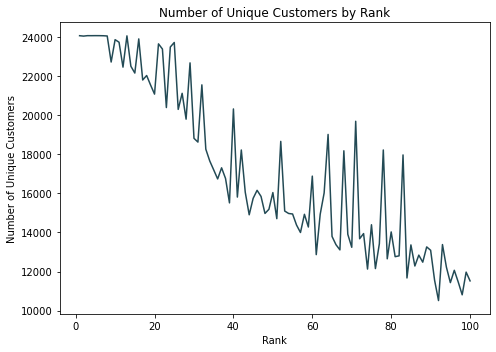

In [35]:
# Plot number of unique customer trend by rank
fig, ax = plt.subplots(1, figsize=(7, 5))
ax = sns.lineplot(top_100['rank'],top_100['unique_customers'], color='#234a55', sort=True)
fig = ax.figure

ax.xaxis.set_tick_params(labelsize=10)
ax.yaxis.set_tick_params(labelsize=10)
ax.set_ylabel('Number of Unique Customers', fontsize=10)
ax.set_xlabel('Rank', fontsize=10)
plt.xticks(rotation=0)
plt.title("Number of Unique Customers by Rank")

fig.tight_layout()
fig.savefig('plots/top_100_unique_customers.png', dpi=300)


Based on the number of unique customers by rank plot above, it is clear that the plot shows a downward trend as rank increases. This follows closely with our expectation where the number of unique customers should progressively decrease as rank goes to 100.
<br>
<br>
<br>

- ### 2. Average monthly commission by rank

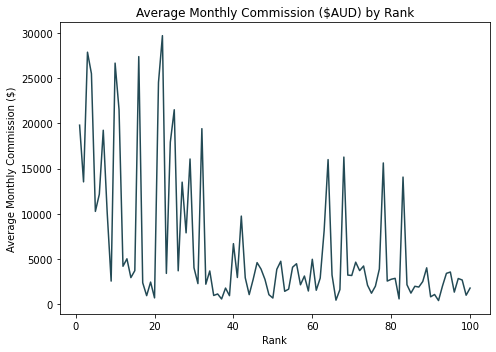

In [36]:
# Plot average monthly commission trend by rank
fig, ax = plt.subplots(1, figsize=(7, 5))
ax = sns.lineplot(top_100['rank'],top_100['commission_avg_tot_dollar_value_monthly'], color='#234a55', sort=True)
fig = ax.figure

ax.xaxis.set_tick_params(labelsize=10)
ax.yaxis.set_tick_params(labelsize=10)
ax.set_ylabel('Average Monthly Commission ($)', fontsize=10)
ax.set_xlabel('Rank', fontsize=10)
plt.xticks(rotation=0)
plt.title("Average Monthly Commission ($AUD) by Rank")

fig.tight_layout()
fig.savefig('plots/top_100_monthly_commission.png', dpi=300)


Similarly, the plot shows a **general downward trend as rank increases** but there's much more variance this time. This happens as there exists tradeoffs in each merchant (eg. high in number of order/customers but low in take rate/commission contributed) thus we cannot have a smooth downward trend for all metrics. However, the general downward trend tells us that the ranking system follow closely with our expectation where the average monthly commission should progressively decrease as rank goes to 100. 
<br>
<br>
<br>

- ### 3. Overall fraud rate by rank

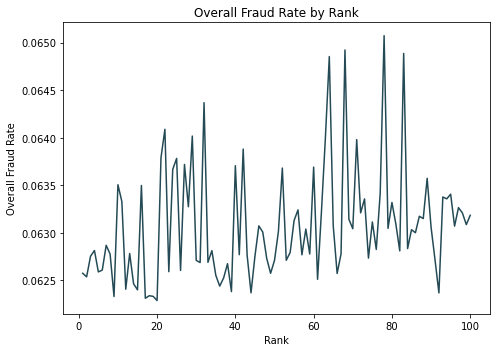

In [37]:
# Plot overall fraud rate trend by rank
fig, ax = plt.subplots(1, figsize=(7, 5))
ax = sns.lineplot(top_100['rank'],top_100['rate_fraud_order'], color='#234a55', sort=True)
fig = ax.figure

ax.xaxis.set_tick_params(labelsize=10)
ax.yaxis.set_tick_params(labelsize=10)
ax.set_ylabel('Overall Fraud Rate', fontsize=10)
ax.set_xlabel('Rank', fontsize=10)
plt.xticks(rotation=0)
plt.title("Overall Fraud Rate by Rank")

fig.tight_layout()
fig.savefig('plots/top_100_overall_fraud_rate.png', dpi=300)


On the other hand, the overall fraud rate plot shows a **general upward trend as rank increases** which is expected theoretically since we expect the overall merchants' fraud rate to get progressively worse as rank goes to 100.
<br>
<br>
<br>

- ### 4. Average monthly orders by rank

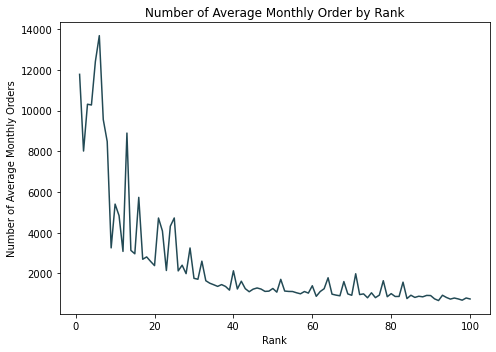

In [38]:
# Plot number of average monthly orders trend by rank
fig, ax = plt.subplots(1, figsize=(7, 5))
ax = sns.lineplot(top_100['rank'],top_100['avg_num_order_id_monthly'], color='#234a55', sort=True)
fig = ax.figure

ax.xaxis.set_tick_params(labelsize=10)
ax.yaxis.set_tick_params(labelsize=10)
ax.set_ylabel('Number of Average Monthly Orders', fontsize=10)
ax.set_xlabel('Rank', fontsize=10)
plt.xticks(rotation=0)
plt.title("Number of Average Monthly Order by Rank")

fig.tight_layout()
fig.savefig('plots/top_100_avg_monthly_order.png', dpi=300)

Similar to the first two plots, the average monthly orders plot shows a **downward trend as rank increases**. This follows closely with our expectation where the number of average monthly orders should progressively decrease as rank goes to 100. 
<br>
<br>
<br>
<br>

#  <a name="limitations"></a>Assumptions, Limitations & Future Work

This section details various assumptions we've made along the project developments as well as the limitation of our model and potential future work for this project.

- ### Assumptions
    - Assume customers' weekly income **approximates** to the median personal weekly income based on their SA2 region indicated by the ABS data.
    - Commission calculations assume **100% of merchants’ consumers** use our BNPL platform for payments.
    - Features/metrics to maximize in merchants are assumed to **prioritize the prosperity and exposure** of the BNPL company only.


- ### Limitations
    - **ETL script** takes a **long time to run** (~10-20 minutes) due to the astronomical size of data that have to be processed.
    - Our ranking does not account for pillars of **sustainability** (no focus on social or environmental sustainability in metrics).
    - **Lack of ground truth ranking labels** limits the set of approaches in ranking merchants. We do not yet know the preference of executives (eg. they may prefer firm's growth over profit or vice versa) so this makes **quantitative model evaluation difficult**.
    
- ### Future Work
    - Which metrics to be **weighted higher** should be discussed prior to running the ranking algorithm with the business partners or based on company’s **future direction** (firm's growth vs shareholders' profits).
    - Collect **actual commissions earned** and **customer onboarding rate** for a certain period after selecting merchants and analyze which metrics have high and direct impact on the actual commissions earned and customer onboarding rate and tailor this for future merchants selection.

    
<br>
<br>
<br>

# <a name="appendix"></a>Appendix

During the development of the project, we tried different methods in handling the **fraud information** and tested different way of **ranking merchants**. However, these methods were either **too complex** or produced **unfruitful results**.

For more information on the deprecated methods, please check out the **"appendix"** folder under the notebook folder.